# Use machine learning to understand and predict urban flows

This project is aimed to explore the airflow around and behind a high-rising building. The simulation results generated by [urban Dutch Atmospheric Large Eddy Simulation (uDALES) model](https://gmd.copernicus.org/articles/15/5309/2022/) are used as a database to train the Gaussian Mixture Model. With the help of Sparse Principle Component Analysis, the dominant balance physics can be identified within the domain.

Governing equations: the streamwise component of 3-D Reynolds-averaged Navier-Stokes (RANS) equations without viscous term:
$$ [\bar{u} \bar{u}_x + \bar{v} \bar{u}_y]_A + [\bar{w} \bar{u}_z]_B = [\rho^{-1} \bar{p}_x]_C - [(\overline{u'^2})_x + (\overline{u' v'})_y]_D - [(\overline{u'w'})_z]_E $$

Due to the utilization of LES, kinematic viscosity is near zero and can be neglected in RANS

This sector focuses on the x-z plane of the domain, i.e. the side view.

The code is based on the paper written by [Jared Callaham etal. (2020)](https://www.nature.com/articles/s41467-021-21331-z#Sec1)

# Import packages

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randint
import sklearn as sk
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import SparsePCA
from scipy.io import loadmat
import h5py
from scipy import sparse, linalg
from scipy.optimize import curve_fit, root
from scipy.integrate import odeint
from scipy.interpolate import interp1d

import matplotlib as mpl
mpl.rc('font', family='serif')
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', labelsize=20)
mpl.rc('axes', titlesize=20)
%config InlineBackend.figure_format = 'retina'

from matplotlib.colors import ListedColormap

# Seaborn colormap
import seaborn as sns
sns_list = sns.color_palette('deep').as_hex()
sns_list.insert(0, '#ffffff')  # Insert white at zero position
sns_cmap = ListedColormap(sns_list)

cm = sns_cmap

mpl_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
            '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
            '#bcbd22', '#17becf']

# Load data

In [15]:
file = loadmat('560_453_0_148.mat')

# displacement of cell centers
x = np.array(file['x'])
y = np.array(file['y'])
z = np.array(file['z'])

# identify variable length
nx = len(x)
ny = len(y)
nz = len(z)

# side view velocities at cell centers
u = np.array(file['utc_sv'])
v = np.array(file['vtc_sv'])
w = np.array(file['wtc_sv'])

uuxvuy_sv = np.array(file['uuxvuy_sv']) # first term
wuz_sv = np.array(file['wuz_sv']) # second term
dpdx_sv = np.array(file['dpdx_sv']) # third term
lap_u_sv = np.array(file['lap_u_sv']) # laplacian
uvpyuupx_sv = np.array(file['uvpyuupx_sv']) # fourth term
duwdz_sv = np.array(file['duwdz_sv']) # fifth term

nu = 1.5e-5 # kinematic viscosity, due to the use of LES, nu is near zero and could be neglected in RANS

X, Z = np.meshgrid(z, x) # 2-D grid coordinates generation


# 1. Equation space representation

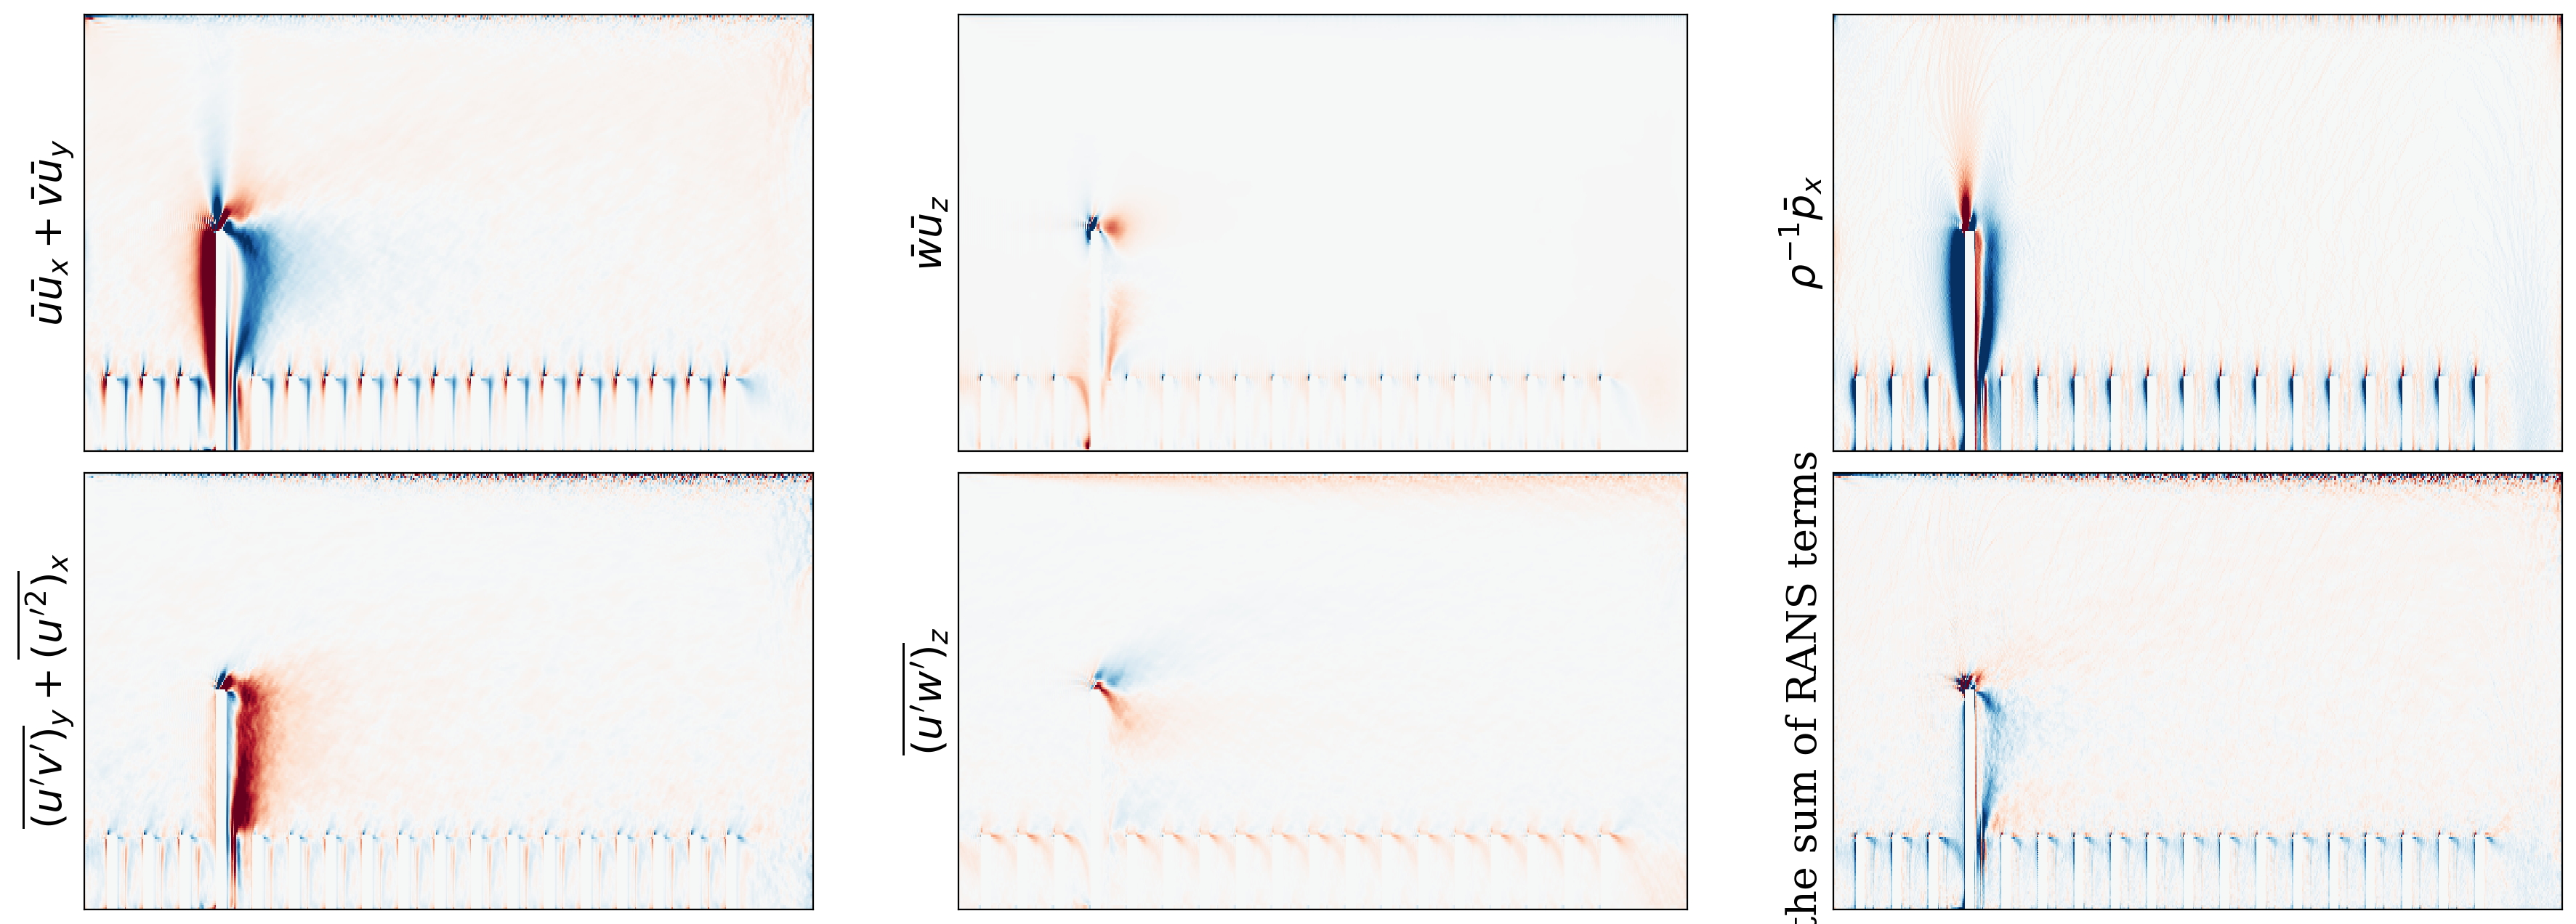

In [16]:
# Plot all 5 terms and the sum of them in the governing equation

plt.figure(figsize=(22, 8))
labels = [r'$\bar{u} \bar{u}_x+\bar{v}\bar{u}_y$',r'$\bar{w}\bar{u}_z$', r'$\rho^{-1} \bar{p}_x$',
          r'$\overline{(u^\prime v^\prime)}_y+\overline{({u^\prime} ^2)}_x$',r'$\overline{(u^\prime w^\prime)}_z$']
clim = 0.1
fontsize=20

plt.subplot(231)
plt.pcolor(Z, X, uuxvuy_sv, vmin=-clim, vmax=clim, cmap='RdBu')
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.ylabel(labels[0], fontsize=fontsize)

plt.subplot(232)
plt.pcolor(Z, X, wuz_sv, vmin=-clim, vmax=clim, cmap='RdBu')
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.ylabel(labels[1], fontsize=fontsize)

plt.subplot(233)
plt.pcolor(Z, X, dpdx_sv, vmin=-clim, vmax=clim, cmap='RdBu')
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.ylabel(labels[2], fontsize=fontsize)

# plt.subplot(234)
# plt.pcolor(Z, X, nu*lap_u_sv, vmin=-clim, vmax=clim, cmap='RdBu')
# plt.gca().set_xticks([])
# plt.gca().set_yticks([])
# plt.ylabel(labels[3], fontsize=fontsize)

plt.subplot(234)
plt.pcolor(Z, X, uvpyuupx_sv, vmin=-clim, vmax=clim, cmap='RdBu')
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.ylabel(labels[3], fontsize=fontsize)

plt.subplot(235)
plt.pcolor(Z, X, duwdz_sv, vmin=-clim, vmax=clim, cmap='RdBu')
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.ylabel(labels[4], fontsize=fontsize)

plt.subplot(236)
plt.pcolor(Z, X, uuxvuy_sv+wuz_sv+dpdx_sv+uvpyuupx_sv+duwdz_sv, vmin=-clim, vmax=clim, cmap='RdBu')
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.ylabel('the sum of RANS terms', fontsize=fontsize)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.05)

plt.show()

# 2. Gaussian mixture model

In [17]:
# Train Gaussian mixture model

# Horizontal Advection, Vertical Advection, Pressure, Horizontal Reynolds Stresses, Vertical Reynolds Stresses
features = 1e3*np.vstack([uuxvuy_sv.flatten('F'), wuz_sv.flatten('F'), dpdx_sv.flatten('F'), uvpyuupx_sv.flatten('F'), duwdz_sv.flatten('F')]).T
nfeatures = features.shape[1]
        
# Fit Gaussian mixture model
nc = 6  # Number of clusters
seed = 0 #  Keep a seed for debugging/plotting
print(seed)

# default tolerance=1e-3, max iteration=100
model = GaussianMixture(n_components=nc, tol=1e-20, max_iter=1000000, random_state=seed)

# PERMUTATION
mask = np.random.permutation(features.shape[0])[:int(features.shape[0])]
model.fit(features[mask, :])

0


GaussianMixture(max_iter=1000000, n_components=6, random_state=0, tol=1e-20)

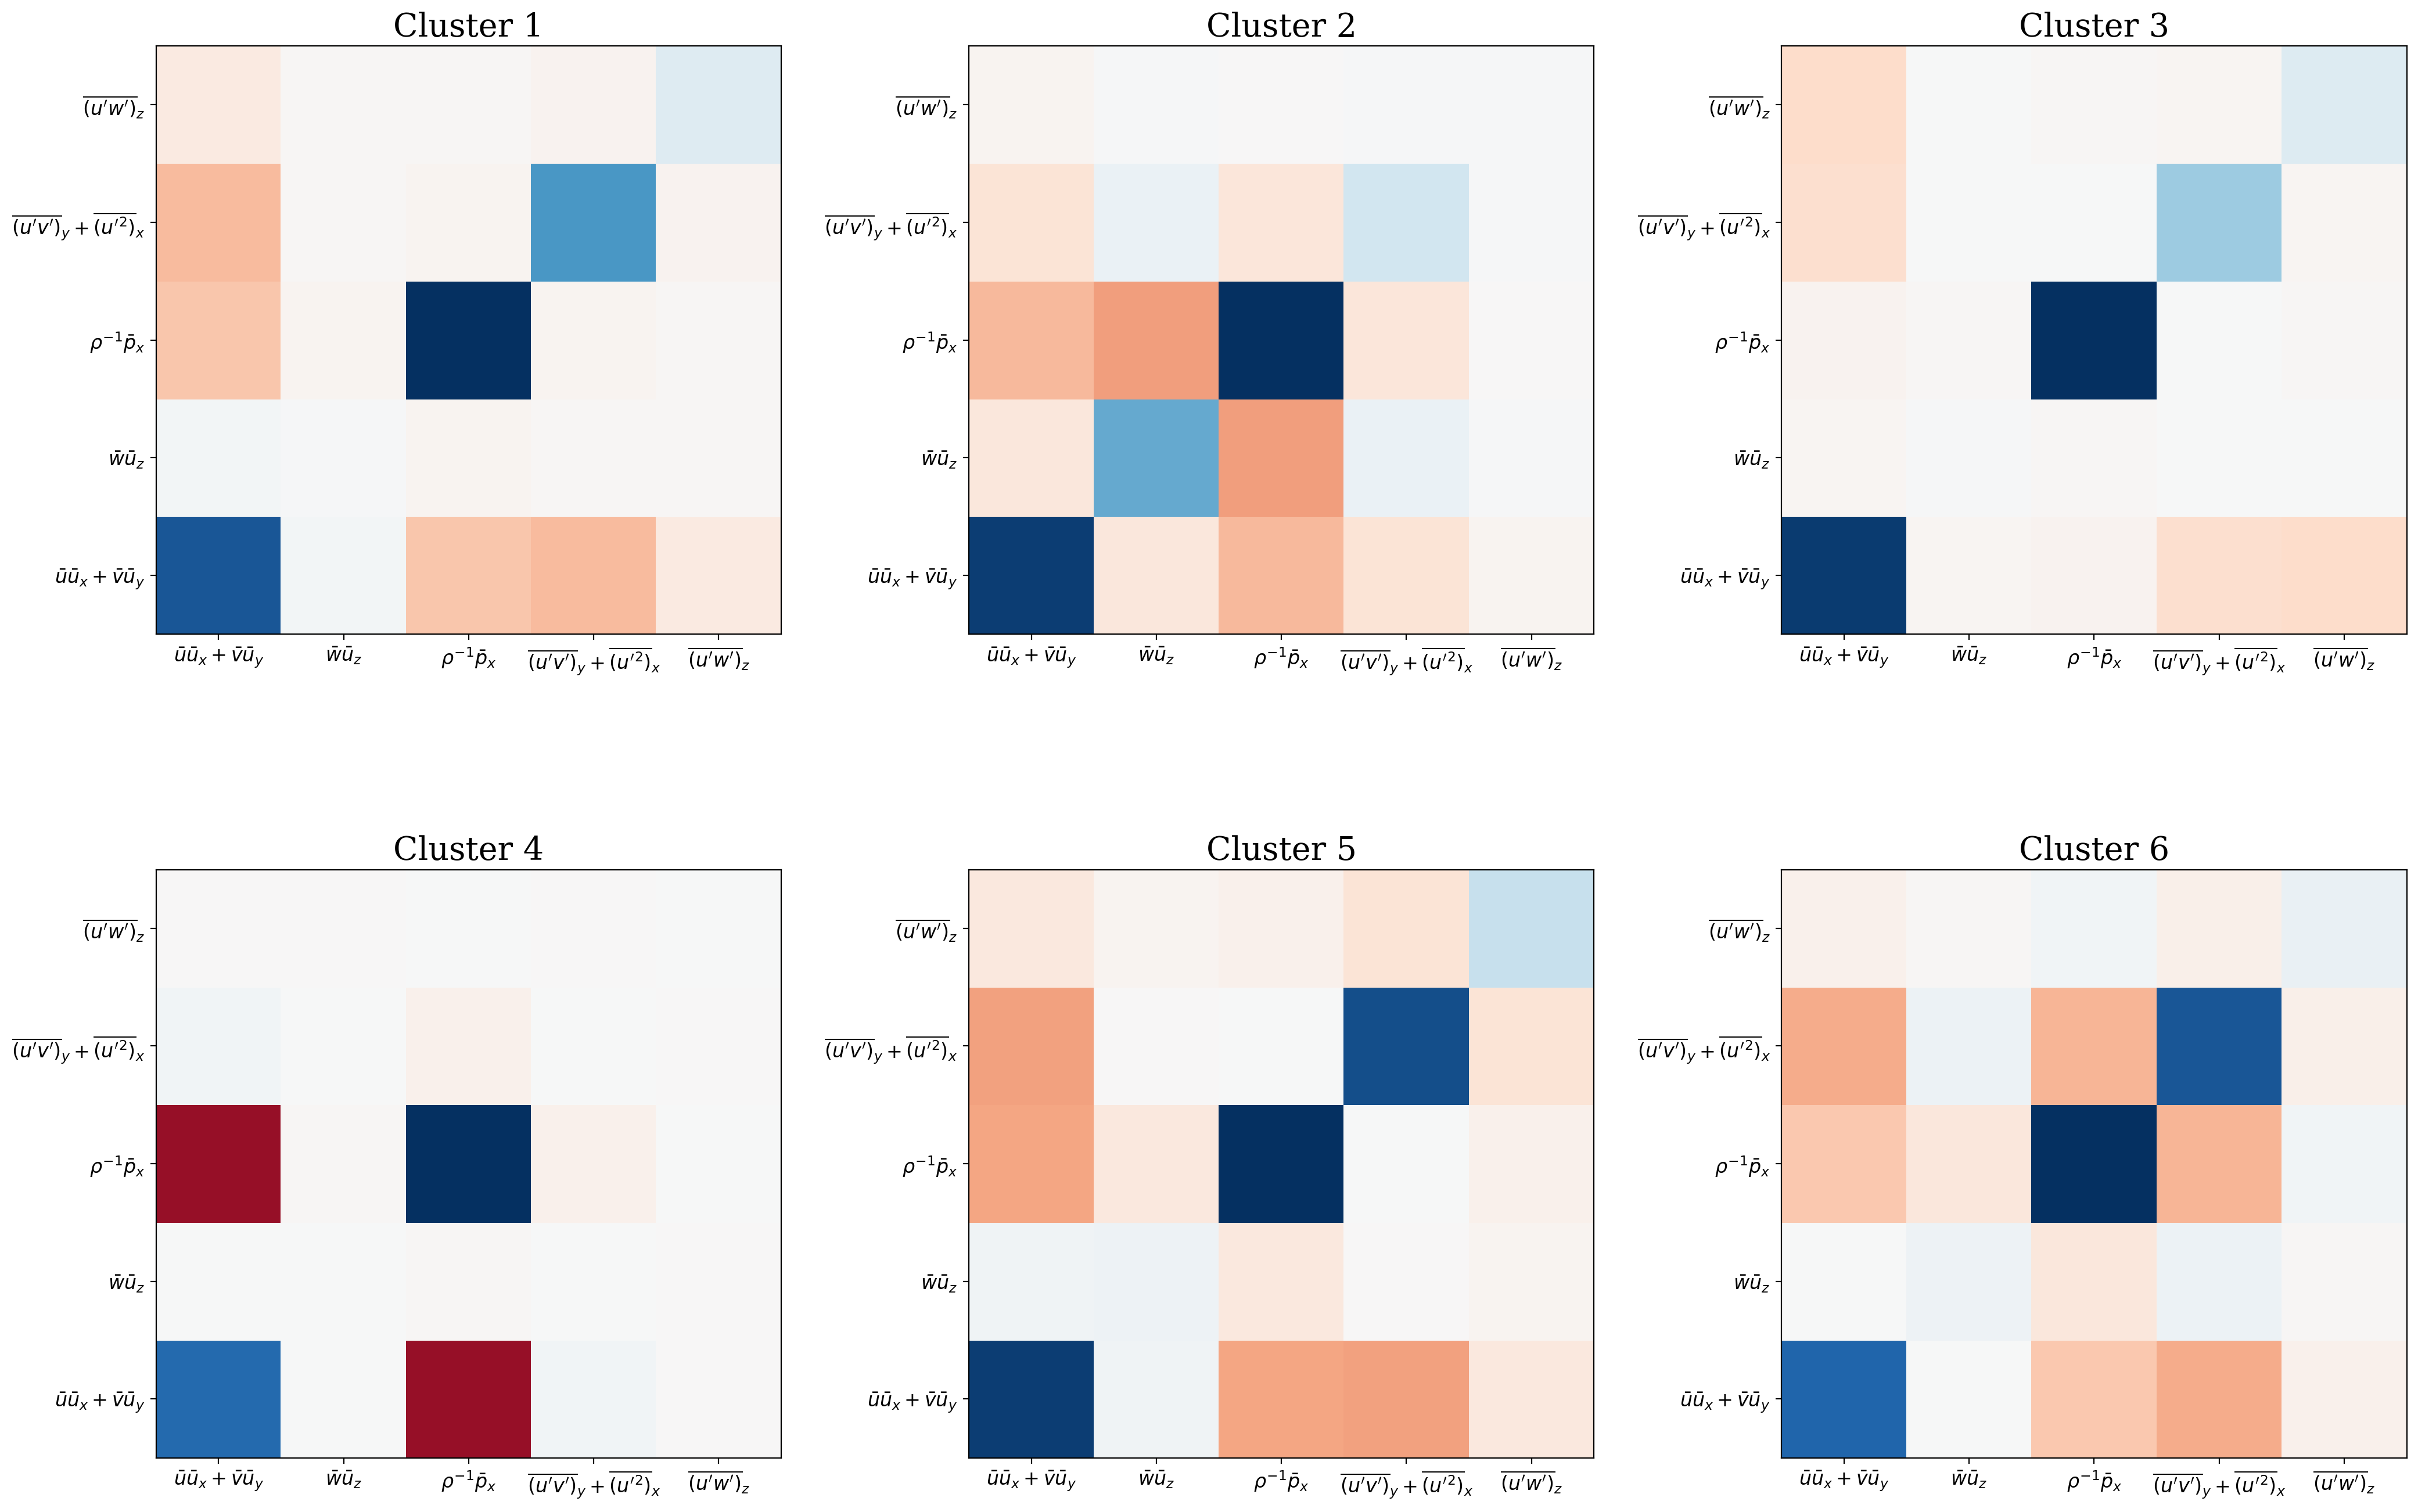

In [158]:
# Plot covariance matrices for the GMM

plt.figure(figsize=(25, 25))
for i in range(nc):
    plt.subplot(3, 3, i+1)
    C = model.covariances_[i, :, :]
    plt.pcolor(C, vmin=-max(abs(C.flatten())), vmax=max(abs(C.flatten())), cmap='RdBu')
    plt.gca().set_xticks(np.arange(0.5, nfeatures+0.5))
    plt.gca().set_xticklabels(labels, fontsize=12)
    plt.gca().set_yticks(np.arange(0.5, nfeatures+0.5))
    plt.gca().set_yticklabels(labels, fontsize=12)
    plt.gca().set_title('Cluster {0}'.format(i+1))
    
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)
plt.show()

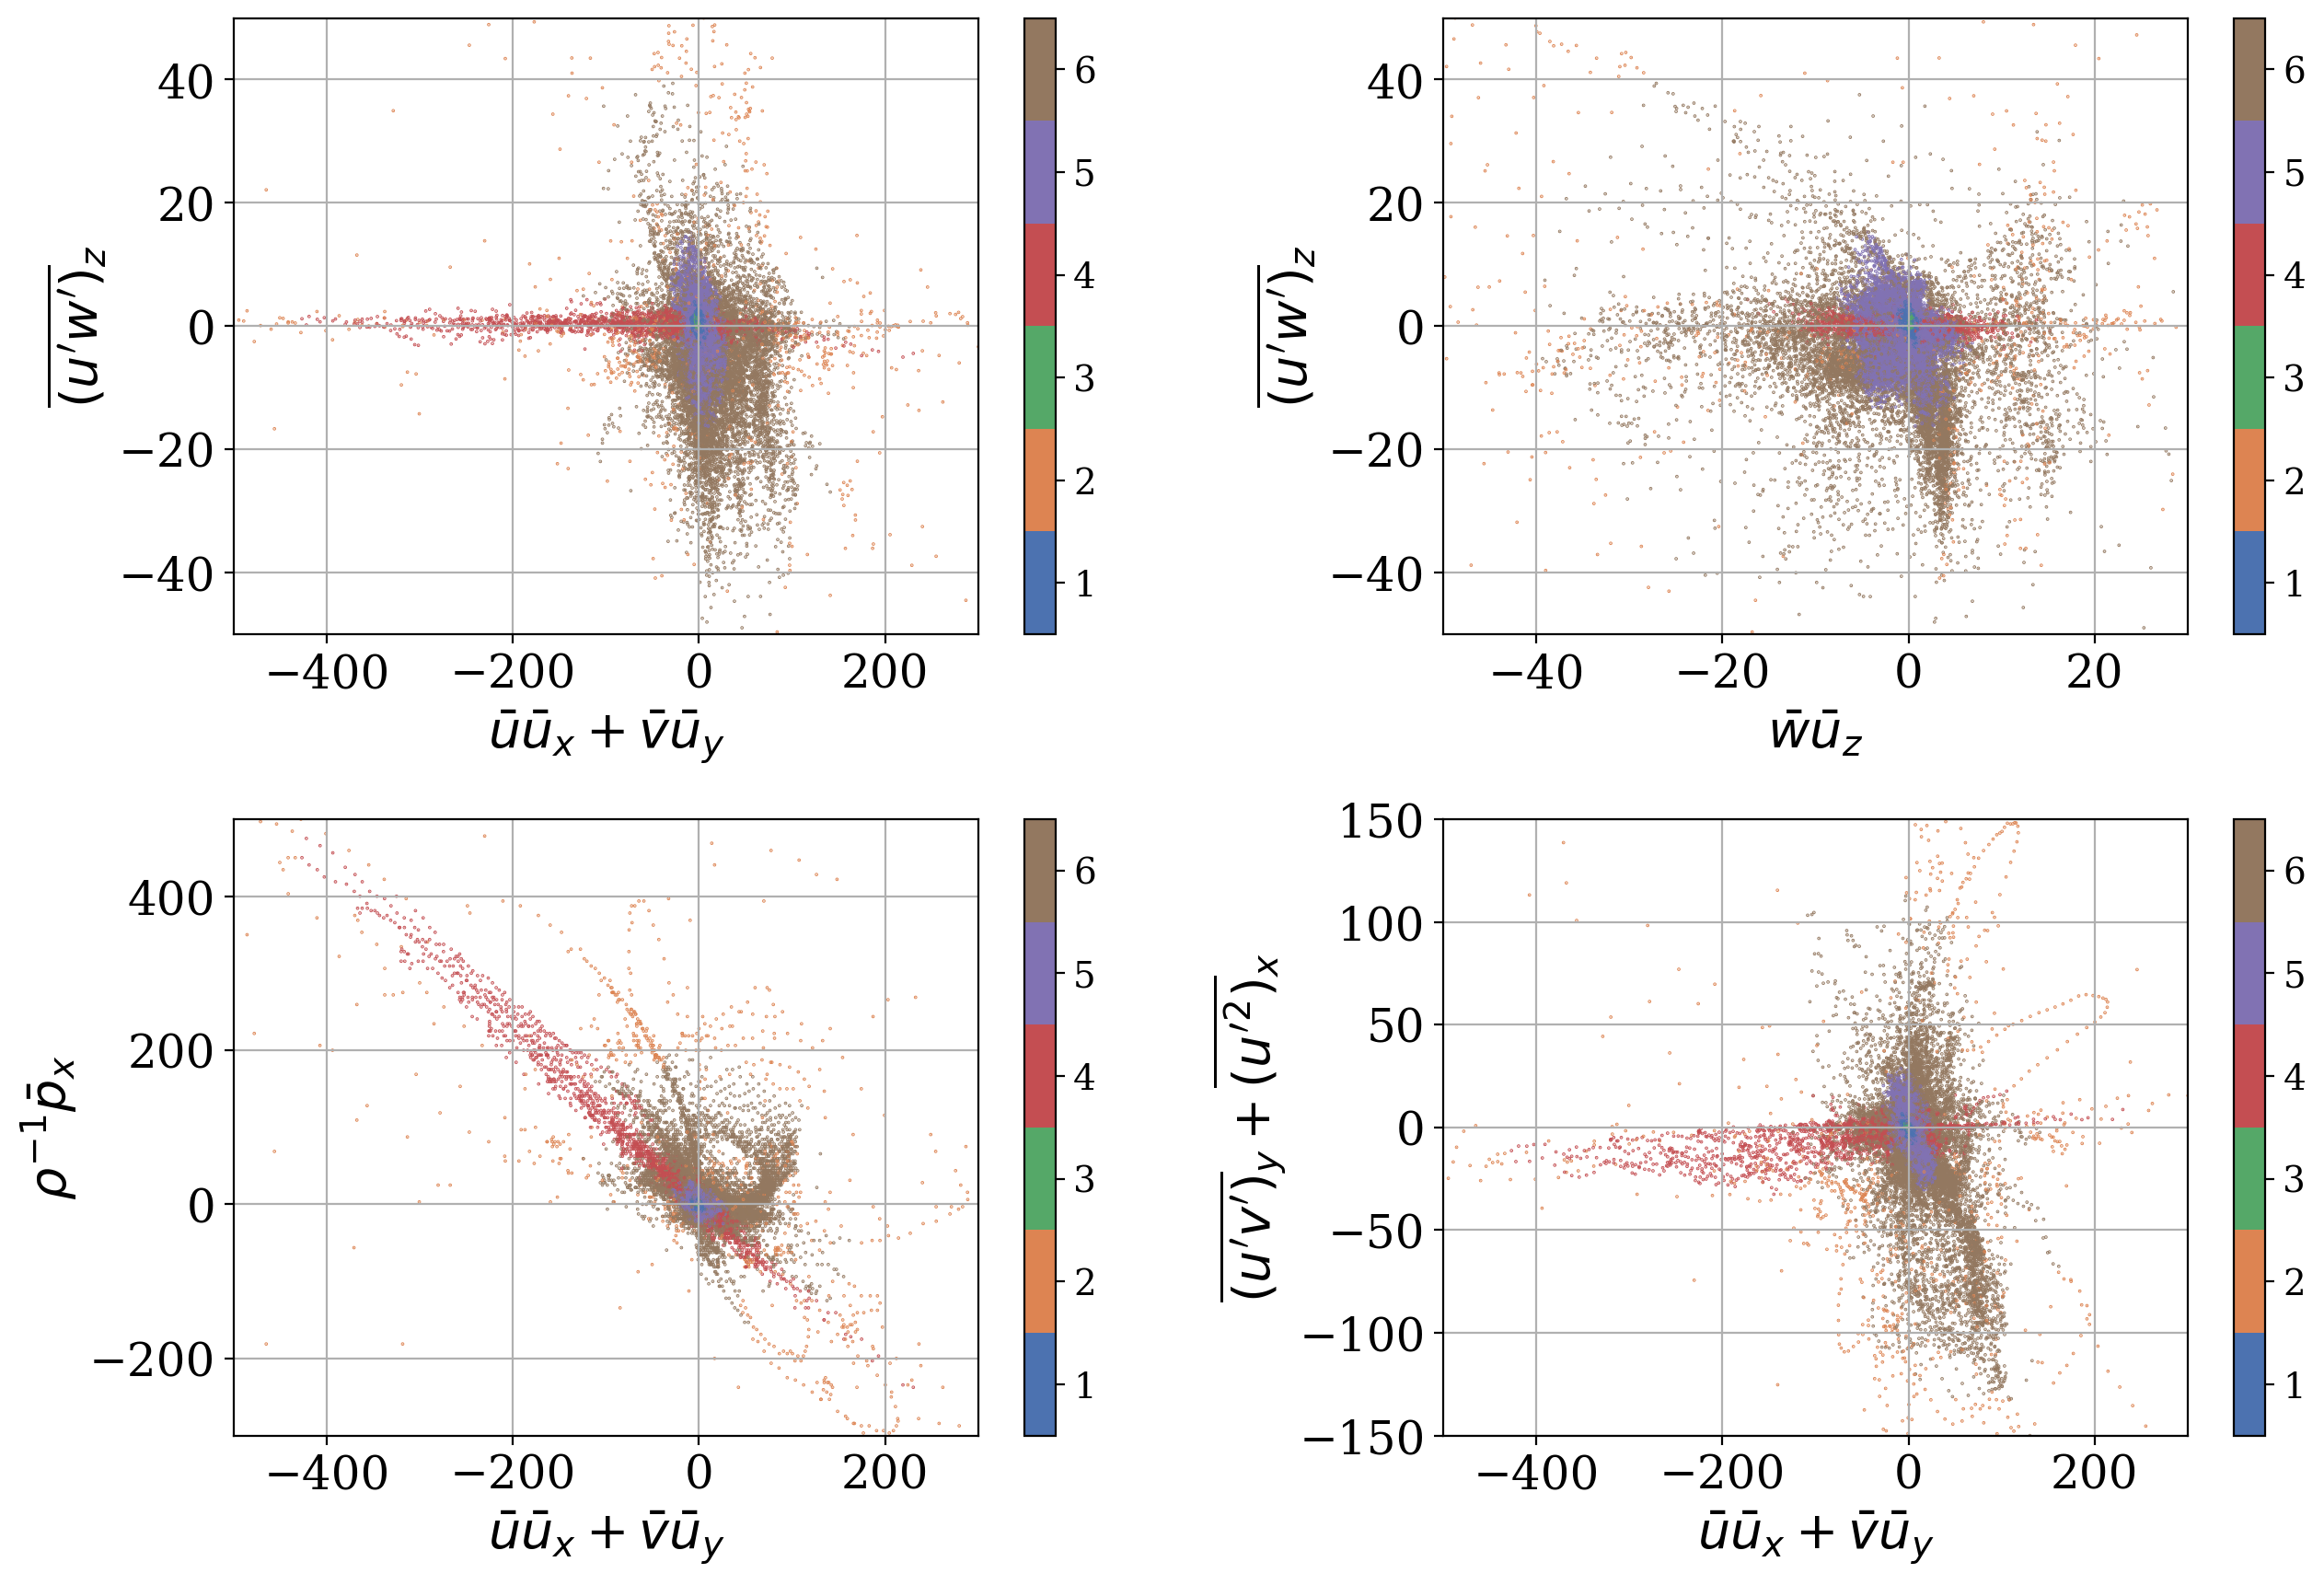

In [198]:
# Visualize GMM clustering with 2D views of equation space

cluster_idx = model.predict(features[mask, :])+1
clim = [.5, cm.N-0.5]
bounds = np.arange(0.5, nc+1.5)

plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.scatter(features[mask, 0], features[mask,4], .1, cluster_idx, cmap=cm)
plt.xlabel(labels[0], fontsize=20)
plt.ylabel(labels[4], fontsize=20)
plt.clim([-.5, cm.N-0.5])
plt.colorbar(boundaries=np.arange(0.5, nc+1.5), ticks=np.arange(1, nc+1))
plt.grid()
plt.xlim([-500, 300])
plt.ylim([-50, 50])

plt.gca().tick_params(axis='both', which='major', labelsize=18)
plt.gca().tick_params(axis='both', which='minor', labelsize=18)

plt.subplot(222)
plt.scatter(features[mask, 1], features[mask,4], .1, cluster_idx, cmap=cm)
plt.xlabel(labels[1], fontsize=20)
plt.ylabel(labels[4], fontsize=20)
plt.clim([-.5, cm.N-0.5])
plt.colorbar(boundaries=np.arange(0.5, nc+1.5), ticks=np.arange(1, nc+1))
plt.grid()
plt.xlim([-50, 30])
plt.ylim([-50, 50])

plt.gca().tick_params(axis='both', which='major', labelsize=18)
plt.gca().tick_params(axis='both', which='minor', labelsize=18)

plt.subplot(223)
plt.scatter(features[mask, 0], features[mask,2], .1, cluster_idx, cmap=cm)
plt.xlabel(labels[0], fontsize=20)
plt.ylabel(labels[2], fontsize=20)
plt.clim([-.5, cm.N-0.5])
plt.colorbar(boundaries=np.arange(0.5, nc+1.5), ticks=np.arange(1, nc+1))
plt.grid()
plt.xlim([-500, 300])
plt.ylim([-300, 500])

plt.gca().tick_params(axis='both', which='major', labelsize=18)
plt.gca().tick_params(axis='both', which='minor', labelsize=18)

plt.subplot(224)
plt.scatter(features[mask, 0], features[mask,3], .1, cluster_idx, cmap=cm)
plt.xlabel(labels[0], fontsize=20)
plt.ylabel(labels[3], fontsize=20)
plt.clim([-.5, cm.N-0.5])
plt.colorbar(boundaries=np.arange(0.5, nc+1.5), ticks=np.arange(1, nc+1))
plt.grid()
plt.xlim([-500, 300])
plt.ylim([-150, 150])

plt.gca().tick_params(axis='both', which='major', labelsize=18)
plt.gca().tick_params(axis='both', which='minor', labelsize=18)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)
plt.show()

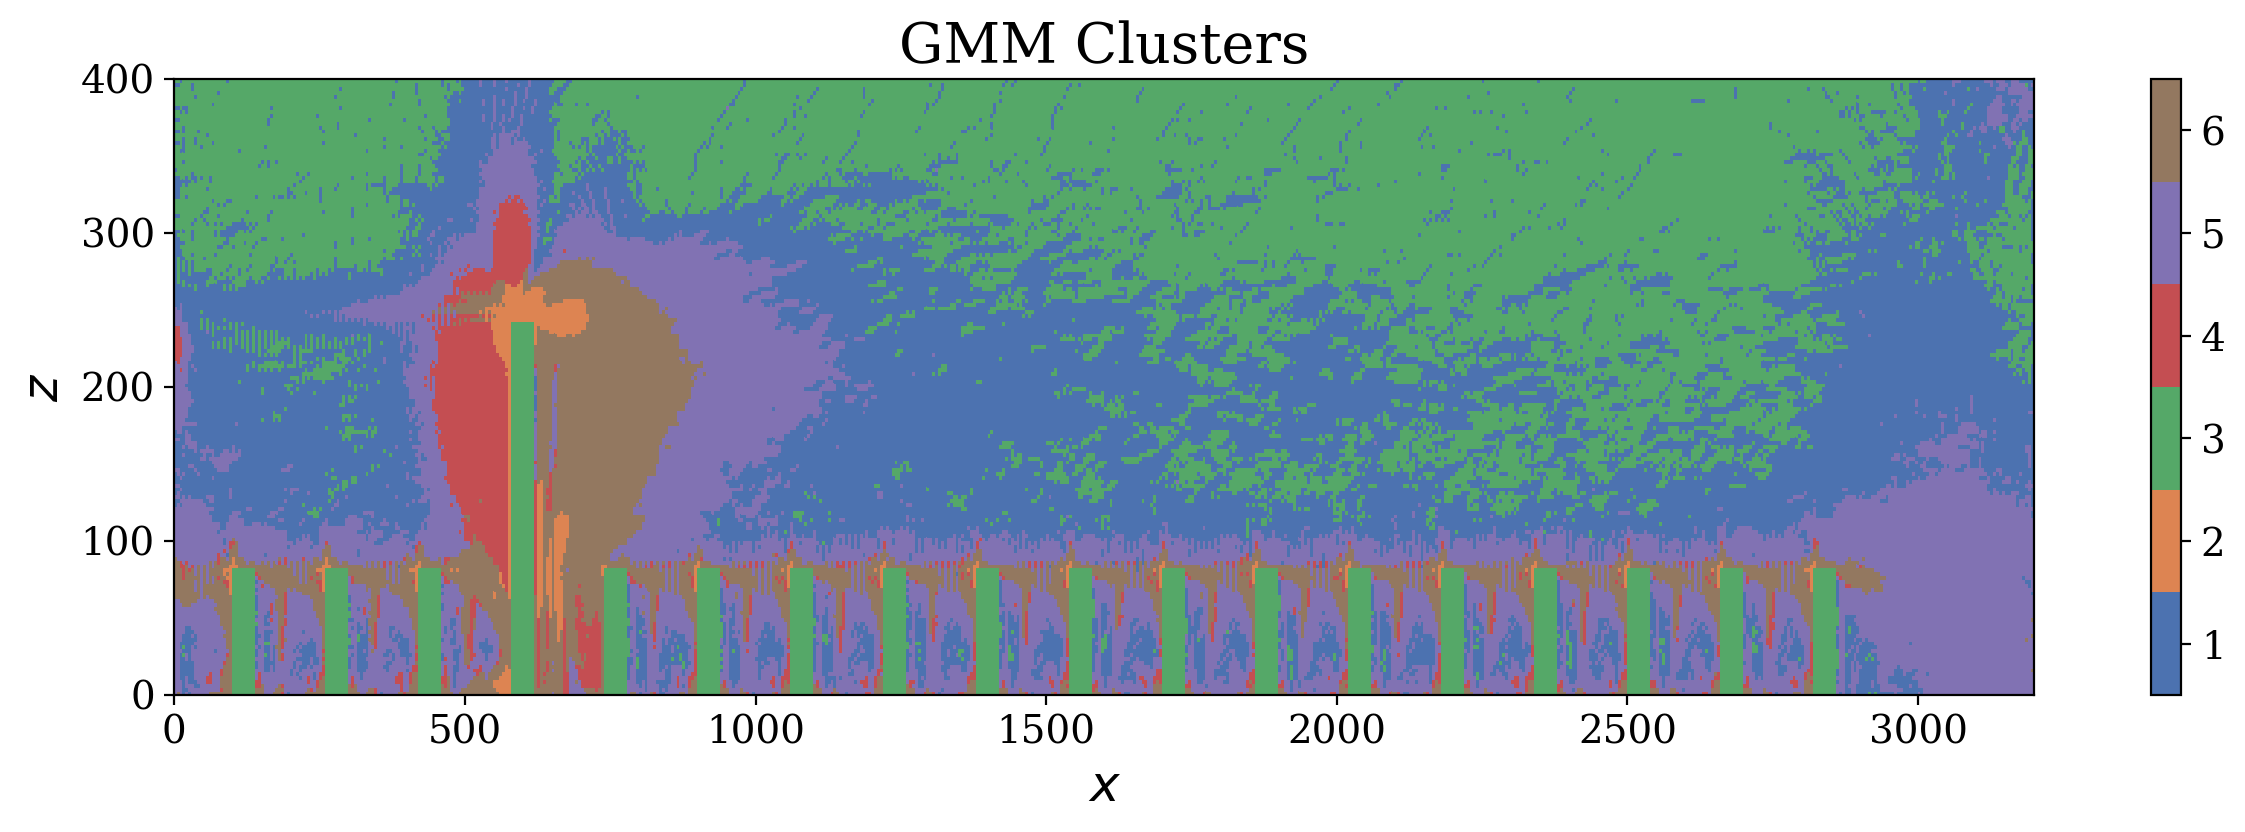

In [201]:
# "Predict" clusters in entire domain

cluster_idx = model.predict(features)
clustermap = np.reshape(cluster_idx, [nx, nz], order='F')

# Colormap of clusters in entire domain

plt.figure(figsize=(15, 4))
plt.pcolor(Z, X, clustermap+1, cmap=cm, vmin=-0.5, vmax=cm.N-0.5)
plt.ylim(0, 400)
plt.colorbar(boundaries=np.arange(0.5, nc+1.5), ticks=np.arange(0, nc+1))

plt.xlabel('$x$', fontsize=18)
plt.ylabel('$z$', fontsize=18)
plt.title('GMM Clusters', fontsize=20)

plt.show()

# 3. RPCA reduction

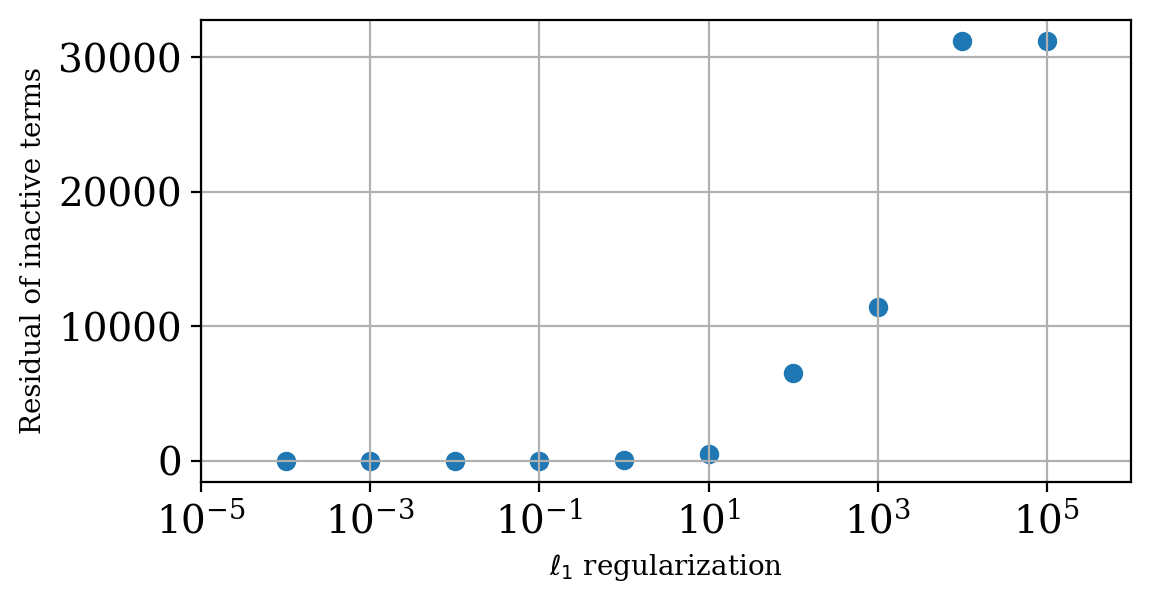

In [202]:
# RPCA to identify directions of nonzero variance
# First step: model selection for L1 regularization
alphas = [1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100, 1e3, 1e4, 1e5]
err = np.zeros([len(alphas)])  # Error defined as norm of inactive terms
sparsity = np.zeros([len(alphas)])

for k in range(len(alphas)):
    for i in range(nc):
        # Identify points in the field corresponding to each cluster
        feature_idx = np.nonzero(cluster_idx==i)[0]
        cluster_features = features[feature_idx, :]
        spca = SparsePCA(n_components=1, alpha=alphas[k])
        spca.fit(cluster_features)
        active_terms = np.nonzero(spca.components_[0])[0]
        inactive_terms = [feat for feat in range(nfeatures) if feat not in active_terms ]
    
        err[k] += np.linalg.norm(cluster_features[:, inactive_terms])
        
plt.figure(figsize=(6, 3))
plt.scatter(alphas, err)
plt.xlabel(r'$\ell_1$ regularization')
plt.ylabel('Residual of inactive terms')
plt.gca().set_xscale('log')
plt.xlim([1e-5, 1e6])
plt.grid()
plt.show()

In [226]:
# RPCA to identify directions of nonzero variance
alpha_opt = 1000

spca_model = np.zeros([nc, nfeatures])
for i in range(nc):
    feature_idx = np.nonzero(cluster_idx==i)[0]
    cluster_features = features[feature_idx, :]
    spca = SparsePCA(n_components=1, alpha=alpha_opt)
    spca.fit(cluster_features)
    print('GMM Cluster {0}:'.format(i+1))
    active_terms = np.nonzero(spca.components_[0])[0]
    if len(active_terms)>0:
        print([labels[k] for k in active_terms])
        spca_model[i, active_terms] = 1  # Set to 1 for active terms in model
    else: print('None')

GMM Cluster 1:
None
GMM Cluster 2:
['$\\bar{u} \\bar{u}_x+\\bar{v}\\bar{u}_y$', '$\\bar{w}\\bar{u}_z$', '$\\rho^{-1} \\bar{p}_x$']
GMM Cluster 3:
None
GMM Cluster 4:
['$\\bar{u} \\bar{u}_x+\\bar{v}\\bar{u}_y$', '$\\rho^{-1} \\bar{p}_x$']
GMM Cluster 5:
['$\\bar{u} \\bar{u}_x+\\bar{v}\\bar{u}_y$']
GMM Cluster 6:
['$\\rho^{-1} \\bar{p}_x$', '$\\overline{(u^\\prime v^\\prime)}_y+\\overline{({u^\\prime} ^2)}_x$']


# 4. Final dominant balance models

In [227]:
balance_models, model_index = np.unique(spca_model, axis=0, return_inverse=True)
nmodels = balance_models.shape[0]
print(balance_models)

for i in range(nmodels):
    print('SPCA Cluster {0}:'.format(i+1))
    active_terms = np.nonzero(balance_models[i, :])[0]
    if len(active_terms)>0:
        print([labels[k] for k in active_terms])
    else: print('No dynamics')

# Make new cluster_idx based on RPCA balance model
balance_idx = np.array([model_index[i] for i in cluster_idx])
balancemap = np.reshape(balance_idx, [nx, nz], order='F')


[[0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0.]
 [1. 1. 1. 0. 0.]]
SPCA Cluster 1:
No dynamics
SPCA Cluster 2:
['$\\rho^{-1} \\bar{p}_x$', '$\\overline{(u^\\prime v^\\prime)}_y+\\overline{({u^\\prime} ^2)}_x$']
SPCA Cluster 3:
['$\\bar{u} \\bar{u}_x+\\bar{v}\\bar{u}_y$']
SPCA Cluster 4:
['$\\bar{u} \\bar{u}_x+\\bar{v}\\bar{u}_y$', '$\\rho^{-1} \\bar{p}_x$']
SPCA Cluster 5:
['$\\bar{u} \\bar{u}_x+\\bar{v}\\bar{u}_y$', '$\\bar{w}\\bar{u}_z$', '$\\rho^{-1} \\bar{p}_x$']


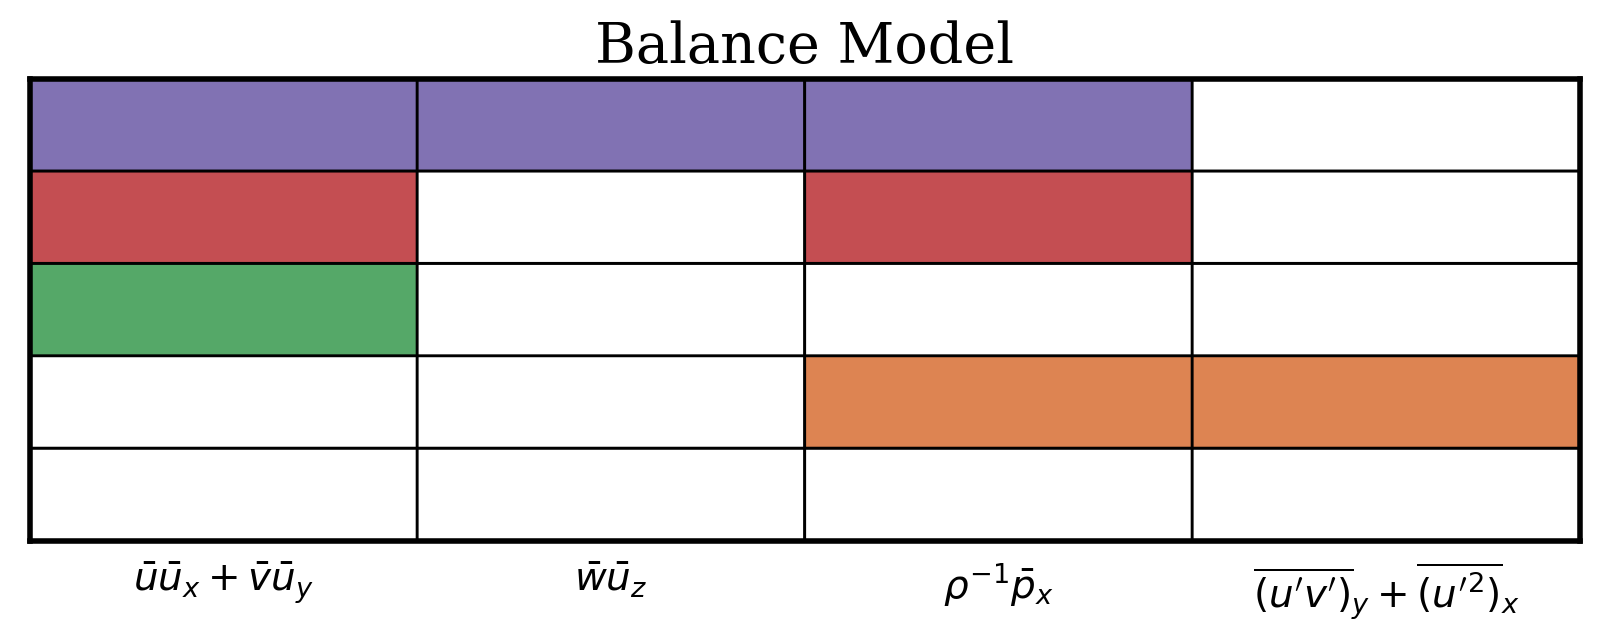

In [228]:
# Plot a grid with active terms in each cluster
gridmap = balance_models.copy()
gridmask = gridmap==0
gridmap = (gridmap.T*np.arange(nmodels)).T+1  # Scale map so that active terms can be color-coded
gridmap[gridmask] = 0

# Delete zero terms
grid_mask = np.nonzero( np.all(gridmap==0, axis=0) )[0]
gridmap = np.delete(gridmap, grid_mask, axis=1)
grid_labels = np.delete(labels, grid_mask)

plt.figure(figsize=(10, 3))
plt.pcolor(gridmap, vmin=-0.5, vmax=cm.N-0.5, cmap=cm, edgecolors='k', linewidth=1)

xlabels = ['$\\bar{u} \\bar{u}_x+\\bar{v}\\bar{u}_y$', '$\\bar{w}\\bar{u}_z$', '$\\rho^{-1} \\bar{p}_x$',
          '$\\overline{(u^\\prime v^\\prime)}_y+\\overline{({u^\\prime} ^2)}_x$']
             
plt.gca().set_xticks(np.arange(0.5, gridmap.shape[0]-0.5), labels=xlabels)

plt.gca().set_yticklabels([])

plt.title('Balance Model')

for axis in ['top','bottom','left','right']:
    plt.gca().spines[axis].set_linewidth(2)

plt.gca().tick_params(axis='both', width=0)
plt.show()

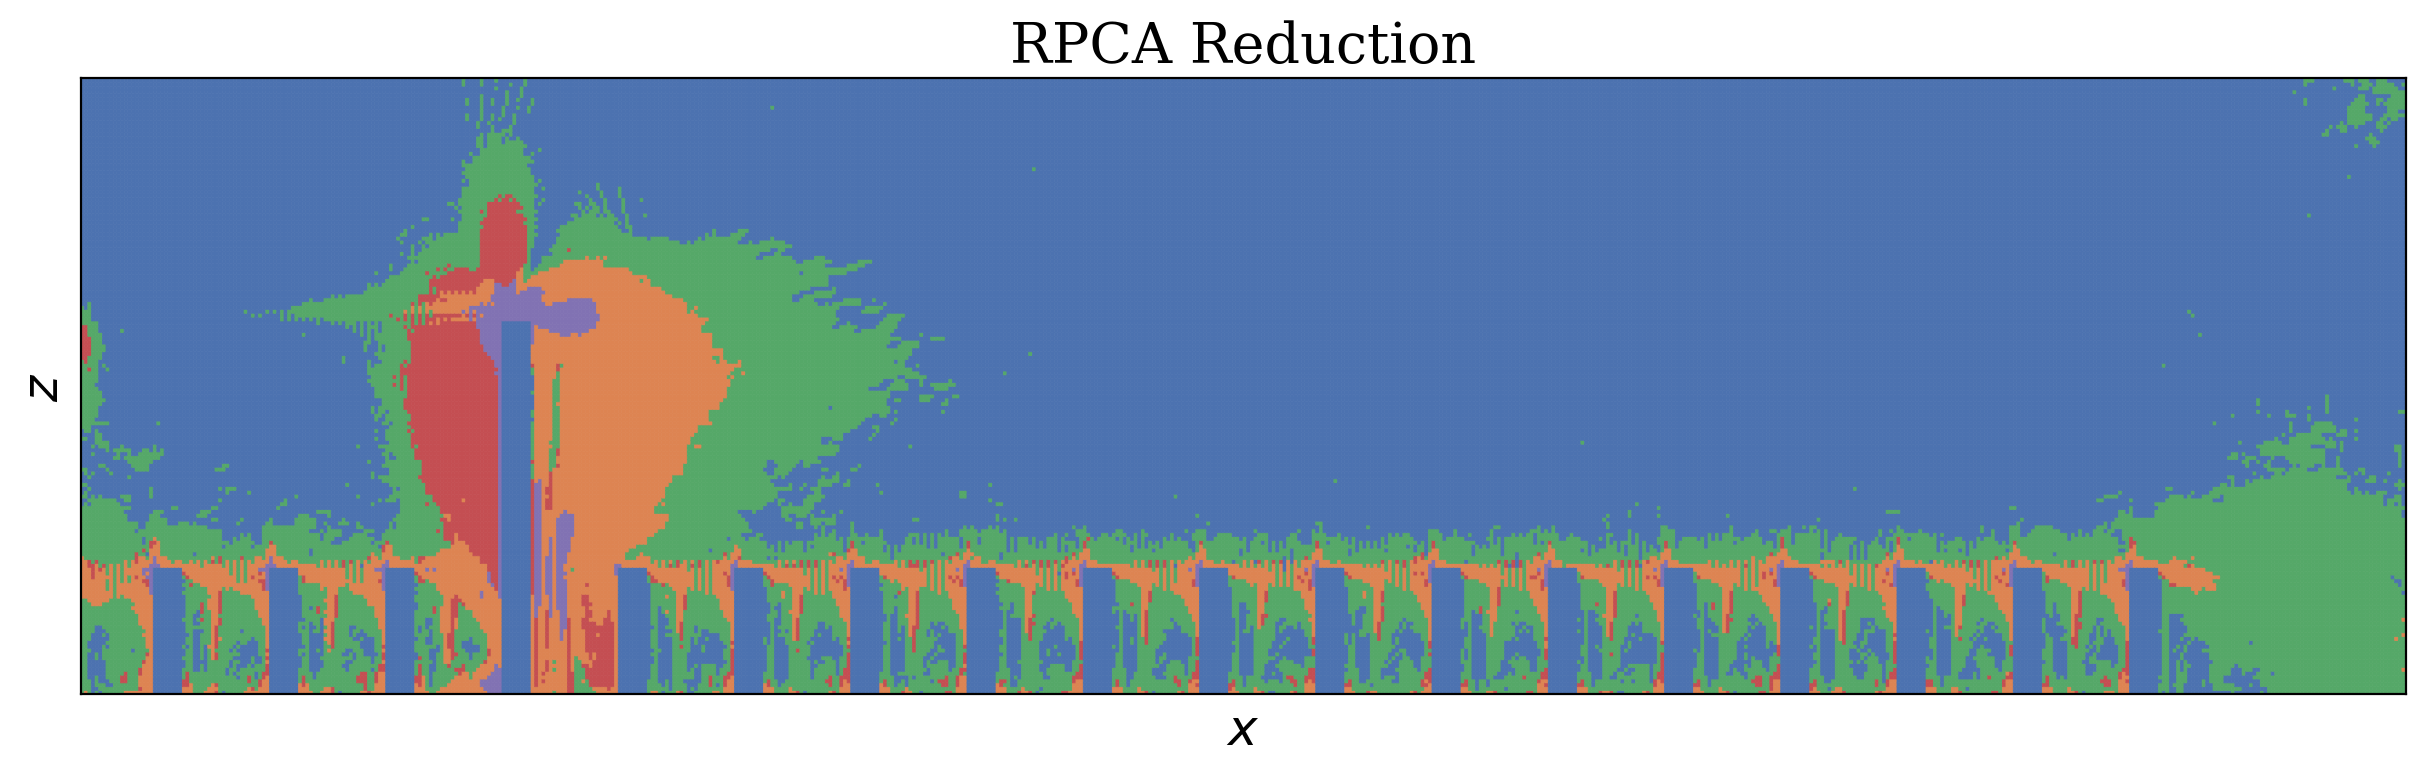

In [229]:

plt.figure(figsize=(15, 4))
plt.pcolor(Z, X, balancemap+1, cmap=cm, vmin=-0.5, vmax=cm.N-0.5, alpha=1, edgecolors='face')
plt.ylim(0, 400)

plt.gca().set_xticks([])
plt.gca().set_yticks([])

plt.xlabel('$x$', fontsize=18)
plt.ylabel('$z$', fontsize=18)
plt.title('RPCA Reduction', fontsize=20)

plt.show()

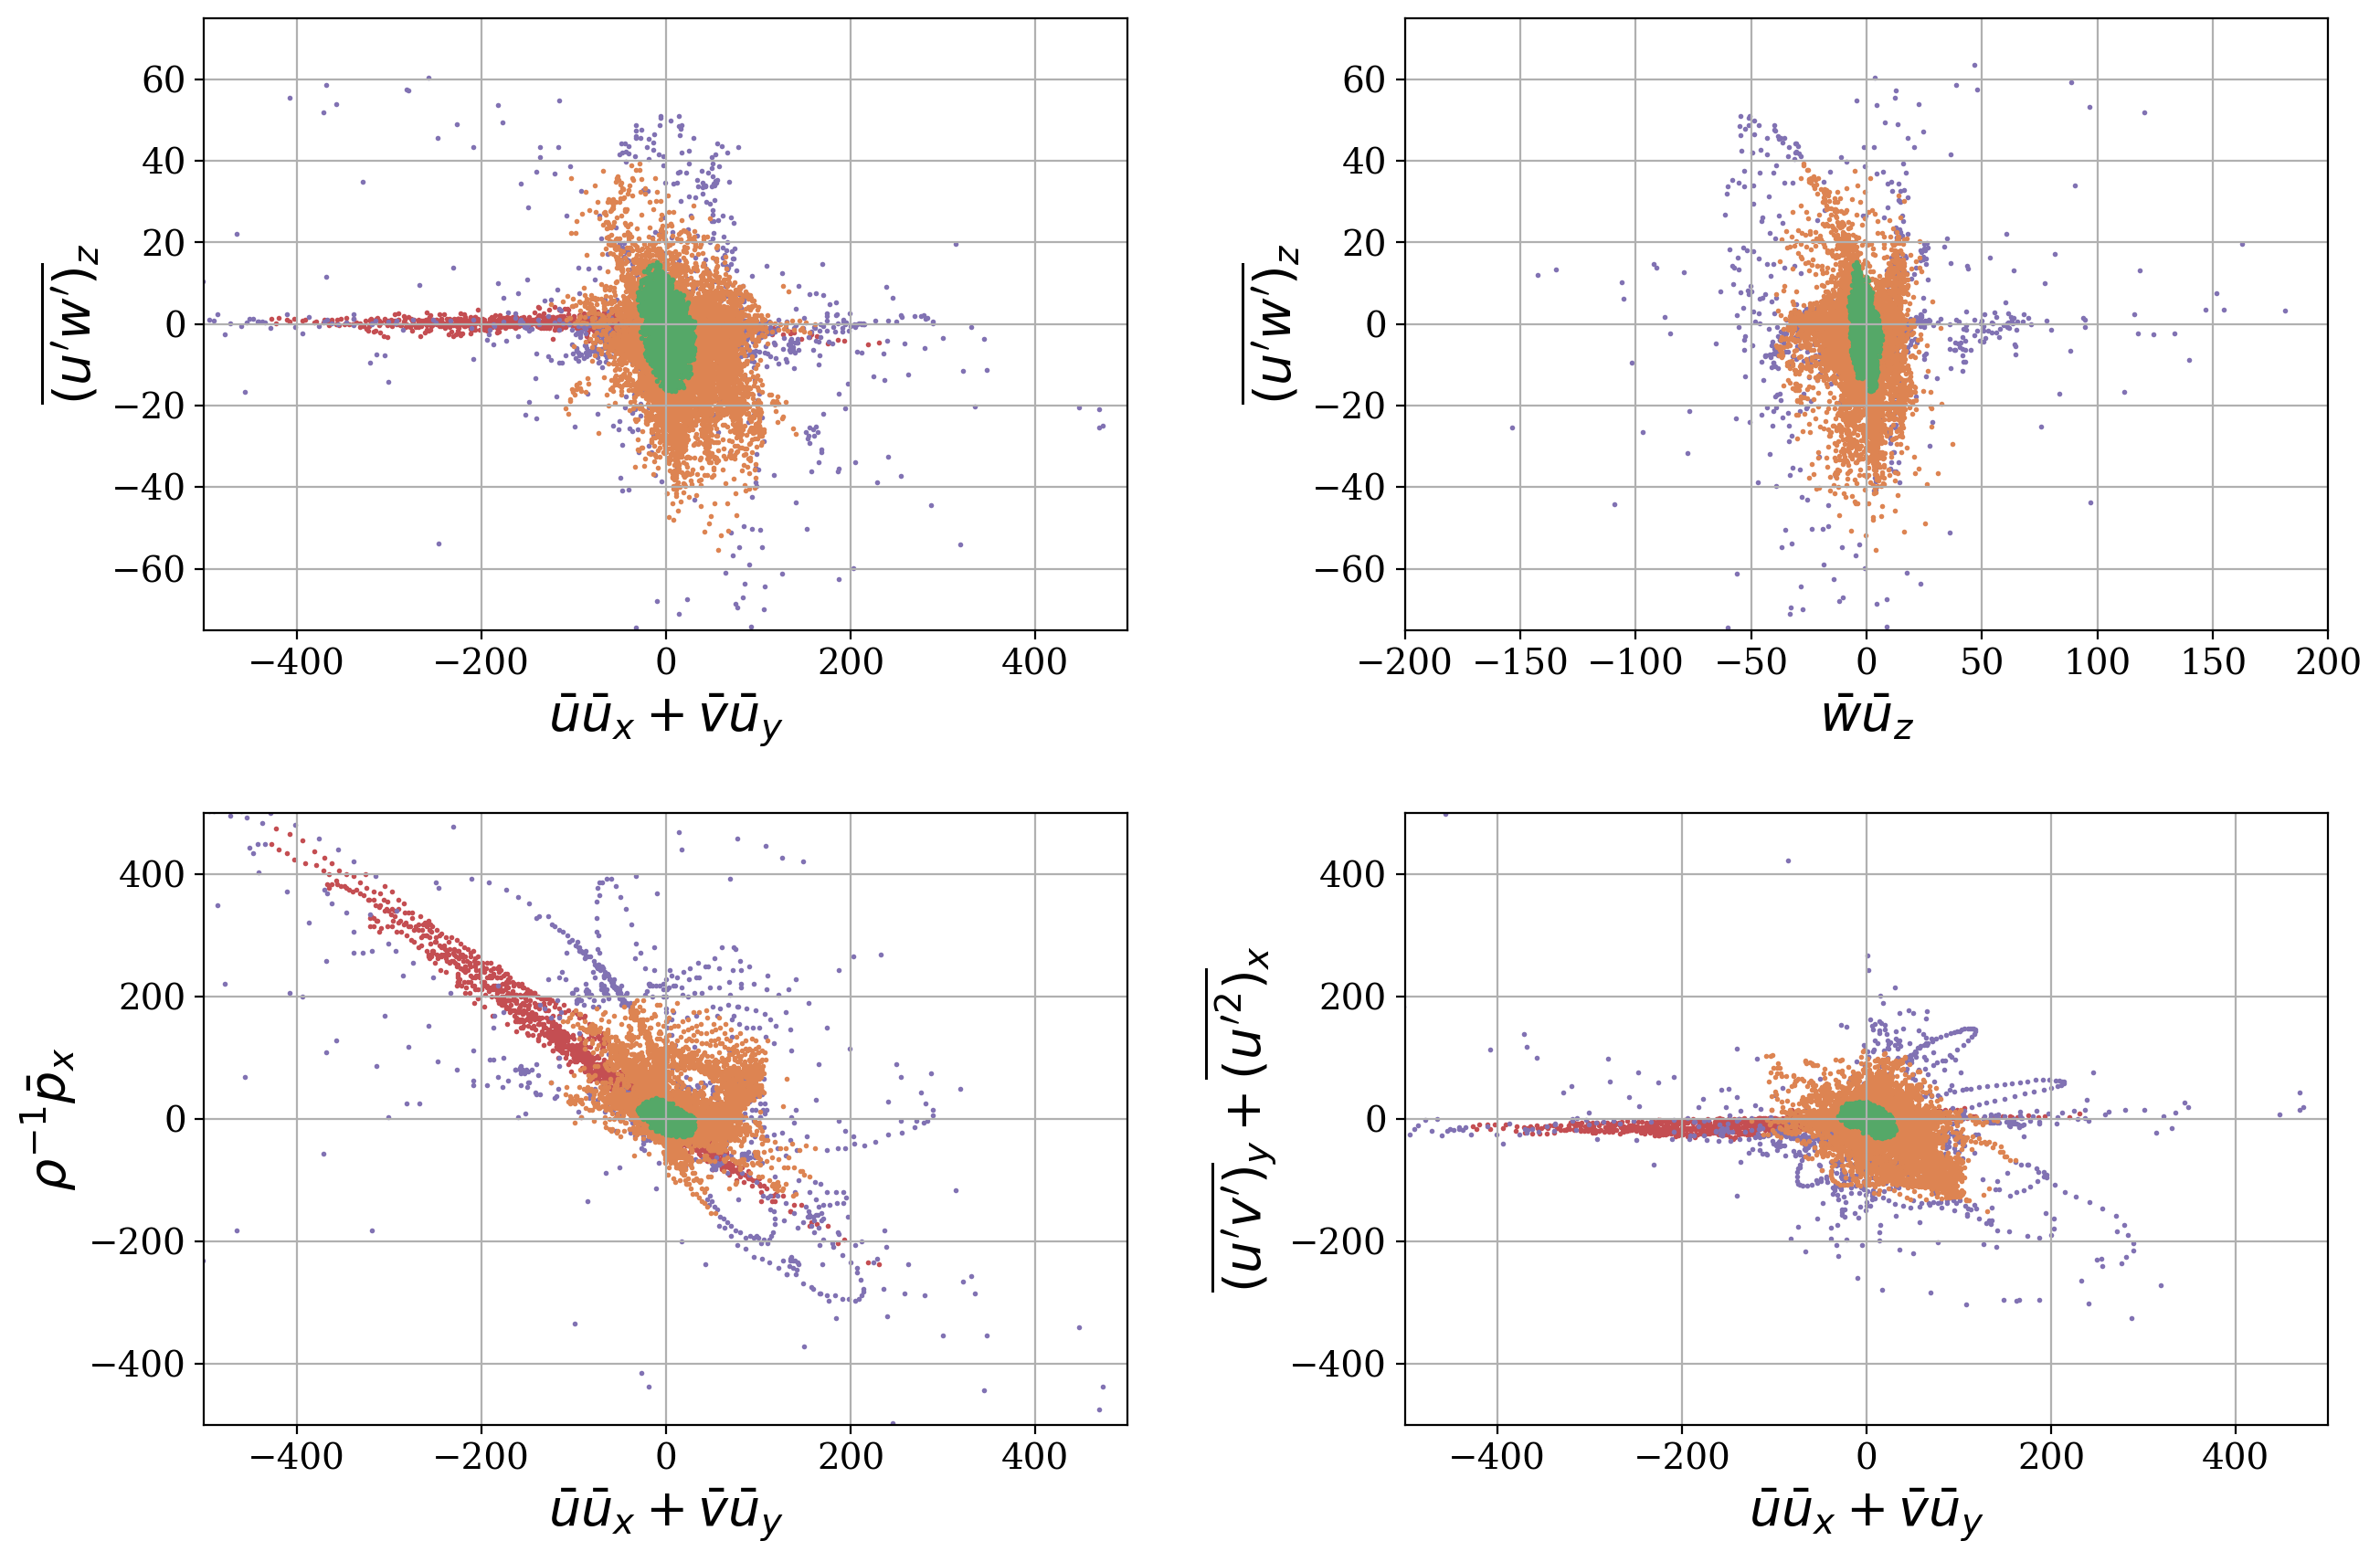

In [240]:
# Plot for figure 1

clim = [.5, cm.N-0.5]
bounds = np.arange(0.5, nmodels+1.5)
fontsize=20
s=1

# Plot order for best visibility
order = [3, 0, 4, 1, 2]

# 2D views of feature space
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
for k in order:
    plt_mask = mask[ np.nonzero(balance_idx[mask]==k) ]
    c = np.array(cm(k+1))[None, :]

    ax[0, 0].scatter(features[plt_mask, 0], features[plt_mask,4], s=s, c=c)
    ax[0,0].set_xlim([-500, 500])
    ax[0,0].set_ylim([-75, 75])

    ax[0, 1].scatter(features[plt_mask, 1], features[plt_mask,4], s=s, c=c)
    ax[0, 1].set_xlim([-200, 200])
    ax[0, 1].set_ylim([-75, 75])

    ax[1, 0].scatter(features[plt_mask, 0], features[plt_mask,2], s=s, c=c)
    ax[1, 0].set_xlim([-500, 500])
    ax[1, 0].set_ylim([-500, 500])

    ax[1, 1].scatter(features[plt_mask, 0], features[plt_mask,3], s=s, c=c)
    ax[1, 1].set_xlim([-500, 500])
    ax[1, 1].set_ylim([-500, 500])

ax[0,0].set_xlabel(labels[0], fontsize=fontsize)
ax[0,0].set_ylabel(labels[4], fontsize=fontsize)

ax[0,1].set_xlabel(labels[1], fontsize=fontsize)
ax[0,1].set_ylabel(labels[4], fontsize=fontsize)

ax[1,0].set_xlabel(labels[0], fontsize=fontsize)
ax[1,0].set_ylabel(labels[2], fontsize=fontsize)

ax[1,1].set_xlabel(labels[0], fontsize=fontsize)
ax[1,1].set_ylabel(labels[3], fontsize=fontsize)

for i in [0, 1]:
    for j in [0, 1]:
        ax[i,j].grid()

        #ax[i,j].set_xticklabels([])
        #ax[i,j].set_yticklabels([])
        #ax[i,j].tick_params(axis='x', length=10, width=0)
        #ax[i,j].tick_params(axis='y', length=0)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)

plt.show()